<a href="https://colab.research.google.com/github/BrotherKim/Colab/blob/main/SEP531/Wk3_P1_Web_Crawler_1_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [SEP 531] 정보검색 실습: Web Crawler 1 - Weather Information

Primary TA: 임채균

TA's E-mail: rayote@kaist.ac.kr

본 실습에서는 웹문서 크롤링 구현을 위해서 HTML 문서 구조를 이해하고, 웹문서 내에서 특정 정보를 파싱하는 과정을 통해 날씨 정보를 구하는 방법을 다룹니다. 


## Contents

1. 웹문서 접근 및 HTML 소스 확인 (네이버 날씨)
  * URL, GET/POST 방식 용어 설명
  * [Python] HTTP request 패키지 (requests)

2. 날씨 정보 문서구조 비교 (웹브라우저 뷰 vs. HTML 소스)

3. [Python] 데이터 특정파트 파싱 (날씨 정보)
  * 단순 텍스트 함수 활용 (substring, find, split, etc.)
  * HTML 파싱 라이브러리 활용 (BeautifulSoup4)


## References

- 김기현 저, "딥러닝의 자연어처리 캠프"
- 박상윤, "개발상식 시리즈" 블로그, https://velog.io/@pa324

# Part 1: 웹문서 접근 및 HTML 소스 확인 (네이버 날씨)


## (1) 웹사이트 주소의 개념



<img width="500" src="https://media.vlpt.us/post-images/pa324/43314730-092e-11ea-9e05-cf069c31c421/image.png" alt="URL, URN, URI 비교" >

* **Uniform Resource Locator (URL)**
  * 자원
  * 예전에는 URL이 가르키는게 파일 소스
  * 요즘은 Rewrite등의 아파치,톰켓등의 핸들러 때문에 자원이라고 부름
  * 웹사이트 주소가 요청하는 파일이라기 보다는, 구분자로 보는 것
  * 웹 상에 서비스를 제공하는 각 서버들에 있는 파일의 위치를 표시하기 위한 것
    * http://blong.com/work/test.pdf 는 blog.com서버에서 work폴더안의 test.pdf를 요청

* **Uniform Resource Identifier (URI)**
  * 통합 자원 식별자
  * 인터넷에 있는 자원을 나타내는 유일한 주소이다.
  * URI의 존재는 인터넷에서 요구되는 기본조건으로서, 인터넷 프로토콜에 항상 붙어다님
    * ex) http://www.naver.com (http프로토콜임을 명시하고 있음)
  * URI의 하위개념에 URL,URN이 포함되어 있다.
  * URI의 보편적인 형태가 URL인데, URI의 부분집합으로 볼 수 있다.
    * 자원에 접근하기 위해 사용되는 절차
  * 어떤 자원을 가지고 있는 특정한 컴퓨터
  * 컴퓨터 상의 유니크한 자원의 이름(파일명)
  * http://test.com/test.pdf?docid=111 이라는 주소는 URI이지만 URL은 아니다.
    * http://test.com/test.pdf 까지만 URL임(주소의 위치)
  * docid=111이라는 쿼리스트링의 값에 따라 결과가 달라지게됨, 따라서 식별자 역할을 하고 있음
  * http://test.com/test.pdf?docid=111 ,http://test.com/test.pdf?docid=112는 같은 URL을 가지고 다른 URI를 가짐

* **Uniform Resource Name (URN)**
  * 위치와 상관없이 리소스의 이름값을 이용해서 접근하는 방식
  * 노출된 URL은 http://blog.com/syun/222 인데, http://blog.com/syun/list/323으로 * 요청을 보내면 404 response를 받는다. 이를 보완하기 위해서 위치 정보와는 무관하게 리소스를 찾을 수 있게 해주는 방식임
  * 해당 리소스의 위치정보가 아닌 실제 리소소의 이름으로 사용하는 방식

* 정리
  * URI에는 URL,URN이 포함되어 있다. URL은 URI이지만, URI는 URL이 아니다.
  * URL은 인터넷 상의 자원 위치를 나타냄
  * URI는 인터넷 상의 자원을 식별하기 위한 문자열의 구성


<!--
![URL, URN, URI 비교](https://media.vlpt.us/post-images/pa324/43314730-092e-11ea-9e05-cf069c31c421/image.png)



**한국어 WordNet**

| 이름 | 기관 | 웹사이트|
| :--- | :--- | :------ |
| KorLex | 부산대학교 | http://korlex.pusan.ac.kr/ |
| Korean WordNet (KWN) | KAIST | http://wordnet.kaist.ac.kr/ |

-->

## (2) HTTP 요청 방식


* **GET**
  * 요청하는 데이터를 HTTP Request Message의 Header부분의 URI에 담아서 전송
  * URI라는 공간에 담겨서 데이터를 전송하기 때문에, 
    * 데이터 크기가 제한적
    * 보안이 필요한 데이터를 그대로 전송하면 URI에 노출
      * GET은 Request를 할 때, 필요한 데이터를 쿼리 스트링에 담아서 전송
        * 쿼리 스트링 이란, URL의 끝에 ? 다음으로 Key와 Value로 이루워진 파라미터를 의미
        * 다양한 파라미터를 전송하기 위해서는 &로 연결
  * 서버에서 어떤 데이터를 가져와서 보여주는 행위를 의미
  * 서버 데이터나 상태를 변경하는 행위는 하지 않는다.
  * GET요청은 브라우저에서 캐싱할 수 있다. 
    * 따라서, 데이터 크기가 작고 보안이슈가 없다고 GET요청을 보내면 기존에 캐싱된 데이터가 응답할 가능성이 있다.

* **POST**
  * GET방식의 query string과 달리 글자 수 제약 없고 파일 업로드 등의 동작이 가능하다.
  * HTTP Message의 Body에 데이터를 담아서 전송
    * 전송할 수 있는 데이터의 크기가 GET방식보다 크고 보안면에서 상대적으로 좋다.(암호화 하지 않는 이상 큰 차이는 없다.)
    * ssl이용하는 https가 아닌 경우 uri의 쿼리스트링에 데이터를 담아도 평문이고, body에 데이터를 담아도 평문으로 전송되기 때문에 특별이 뛰어나다고 할 수 없다.
  * 서버의 상태나 값을 변경하거나 추가하는데 사용

* **PUT**
  * POST와 달리, 멱등성(idempotent)을 가지고있다.
    * post연산의 경우 리소스를 추가하는 연산이기 때문에, 멱등하지 않지만, put은 반복 수행해도 멱등하다.
  * POST와 달리 클라이언트가 이미 변경 대상 리소스의 위치를 알고 있어서, 대상 리소스를 갱신할 수 있다.(리소스 결정권이 클라이언트에게 있다.)

* **DELETE**
  * 자원을 삭제할 것을 요청
  * 특정 자원에 대한 DELETE의 경우 자원을 더 이상 이용할 수 없어야 하므로 ,DELETE요청을 다시 호출한 경우도 자원은 여전히 사용할 수 없는 상태(멱등성)여야 한다.

## [Python] HTTP request 패키지 (requests)

* `requests`: 특정 웹사이트 주소에 대한 HTTP 요청을 다루는 패키지
* 본 실습에서는 크롤링 목적이므로 `GET` 방식 사용

In [1]:
import requests

# 네이버 메인 페이지 요청
response = requests.get('https://www.naver.com')

# 응답 객체에서 일부분 출력
doc = response.text
print(doc[:1024])


<!doctype html>                          <html lang="ko" data-dark="false"> <head> <meta charset="utf-8"> <title>NAVER</title> <meta http-equiv="X-UA-Compatible" content="IE=edge"> <meta name="viewport" content="width=1190"> <meta name="apple-mobile-web-app-title" content="NAVER"/> <meta name="robots" content="index,nofollow"/> <meta name="description" content="네이버 메인에서 다양한 정보와 유용한 컨텐츠를 만나 보세요"/> <meta property="og:title" content="네이버"> <meta property="og:url" content="https://www.naver.com/"> <meta property="og:image" content="https://s.pstatic.net/static/www/mobile/edit/2016/0705/mobile_212852414260.png"> <meta property="og:description" content="네이버 메인에서 다양한 정보와 유용한 컨텐츠를 만나 보세요"/> <meta name="twitter:card" content="summary"> <meta name="twitter:title" content=""> <meta name="twitter:url" content="https://www.naver.com/"> <meta name="twitter:image" content="https://s.pstatic.net/static/www/mobile/edit/2016/0705/mobile_212852414260.png"> <meta name="twitter:description" content="네이버 메

# Part 2: 날씨 정보 문서구조 비교 (웹브라우저 뷰 vs. HTML 소스)



**예제 웹사이트: 네이버 날씨** https://n.weather.naver.com/

* 웹브라우저 (e.g., 인터넷익스플로러, 크롬, 사파리 등)에서는 HTML 문서에 대한 조사(inspection) 도구를 지원
* 활용 예
  * 사용자에게 보여지는 일반적인 화면은 웹브라우저가 CSS 등 스타일을 적용한 결과물 (왼쪽)
  * 프로그램을 통해 보는 문서는 해당 웹사이트의 HTML 원본 텍스트 (오른쪽)
  * 예제와 같이, 현재 온도, 날씨에 해당하는 태그를 탐색 가능함

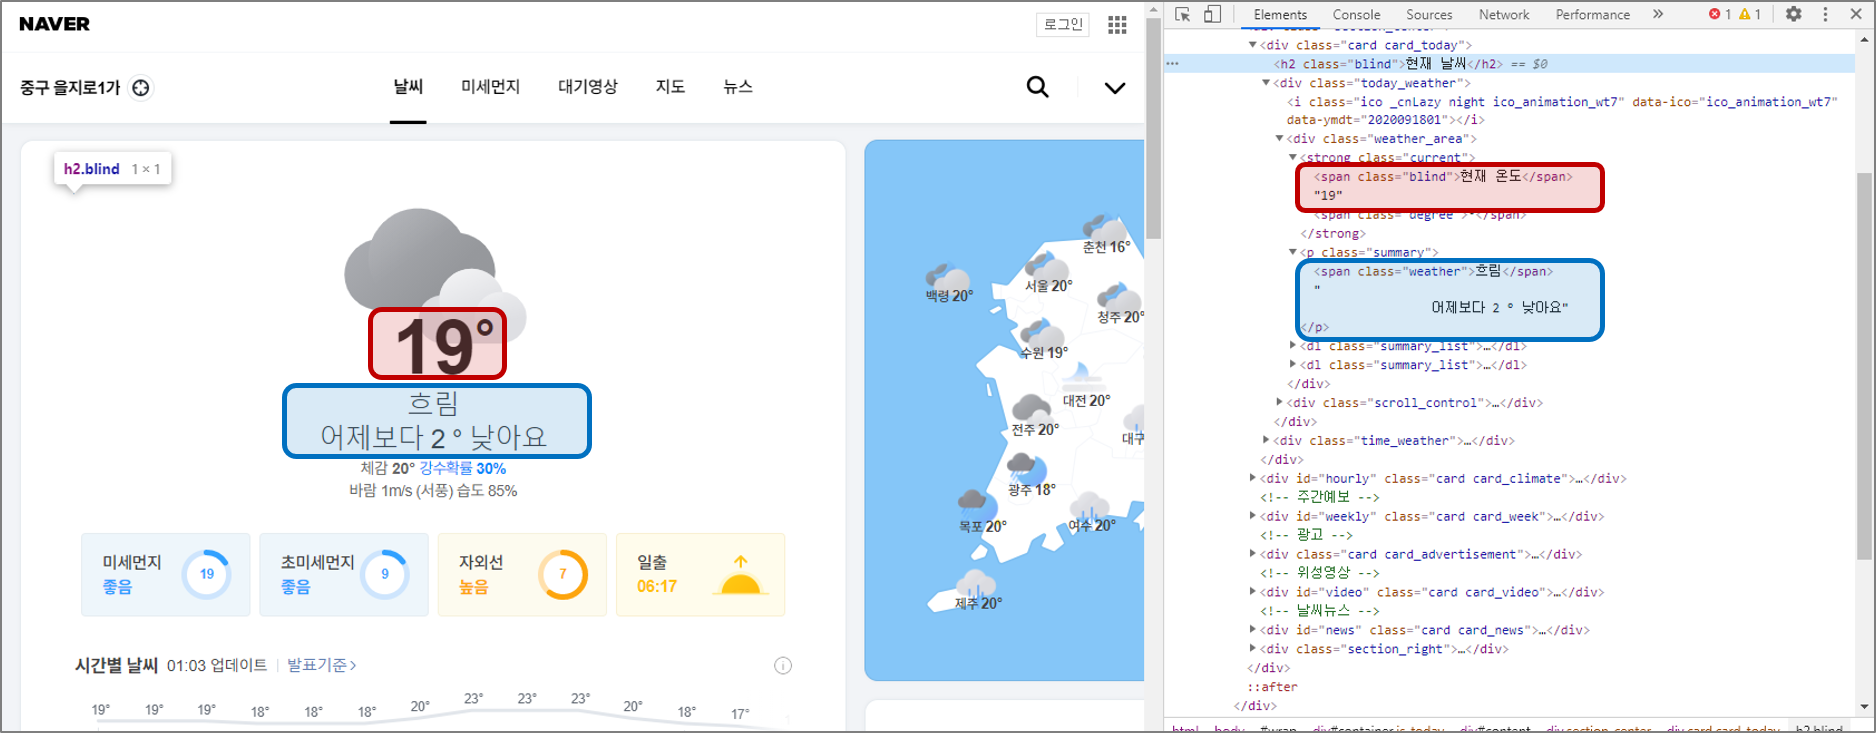

# Part 3: [Python] 데이터 특정파트 파싱 (날씨 정보)


## (1) [Python] 단순 텍스트 함수 활용 (substring, find, split, etc.)


**Step 01: 현재 날씨 웹사이트 접근**

* 위 예시와 같이 네이버 날씨(https://m.weather.naver.com) 를 활용

In [29]:
import requests

# 네이버 메인 페이지 요청
response = requests.get('https://m.weather.naver.com/')

# 응답 객체에서 일부분 출력
doc = response.text
print(doc[:1024])
#print(doc[:])

<!doctype html>
<html lang="ko" data-platform="pc" data-useragent="python-requests/2.23.0">
    <head>
        <meta charset="utf-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge">
<meta name="viewport" content="width=device-width,initial-scale=1.0,user-scalable=no,maximum-scale=1">
<meta name="format-detection" content="telephone=no">
<meta property="og:title" content="네이버 날씨"/>
<meta property="og:url" content="http://weather.naver.com/today"/>
<meta property="og:image" content="https://ssl.pstatic.net/static/weather/m/og_weather.png"/>
<meta property="og:description" content="국내외 날씨와 미세먼지에 대한 종합정보 제공"/>
<link rel="shortcut icon" href="https://ssl.pstatic.net/static/www/nFavicon24.png" type="image/x-icon">
<link rel="preload" href="https://ssl.pstatic.net/static/weather/font/NotoSans-Regular.woff2" as="font" type="font/woff2" crossorigin="anonymous">
    <link rel="preload" href="https://ssl.pstatic.net/static/weather/font/NotoSans-Light.woff2" as="font" type="font/woff2" cross

**Step 02: 현재 날씨에 해당하는 태그 탐색**

* `find()` 함수는 문자열에서 입력 텍스트의 위치(index)를 반환
  * 파라미터로 탐색할 시작 위치를 지정할 수 있음
    * e.g.) `doc.find('현재 날씨', 500)` : `doc` 문자열의 500번째 위치부터 탐색
* 문자열은 List 객체로 취급
  * `VarName[start:end]`와 같은 형식으로 일부 문자열을 자르는 substring 함수의 역할 가능
  * `start`가 없으면 처음 위치부터 포함됨
  * `end`가 없으면 마지막 위치까지 포함됨

In [3]:
# "현재 날씨"의 시작 위치
index = doc.find('현재 날씨')

# 탐색한 위치부터 잘라낸 후, 일부분 출력
content = doc[index:]
print(content[:2048])

현재 날씨</h2>
    <div class="today_weather">
        <div class="cp_area">
            <span class="blind">날씨 제공사 설정</span>
            <ul class="list_cp">
                <li class="item kma on">
                    <button type="button" class="button" data-cp-name="KMA" onclick="nclk_v2(this, 'wtk.cpskmi', '', '')" aria-selected="true"><span class="text">기상청</span></button>
                </li>
                <li class="item accuweather ">
                    <button type="button" class="button" data-cp-name="ACCUWEATHER" onclick="nclk_v2(this, 'wtk.cpsacc', '', '')" aria-selected="false"><span class="text">아큐웨더</span></button>
                </li>
                <li class="item twc ">
                    <button type="button" class="button" data-cp-name="TWC" onclick="nclk_v2(this, 'wtk.cpstwc', '', '')" aria-selected="false"><span class="text">웨더채널</span></button>
                </li>
            </ul>
            <div class="btn_area">
                <button type="button" cla

**Step 03: 특정 정보(현재 온도) 추출**

* 동일한 방식으로 추출할 영역의 패턴을 확인하고, 원하는 문자열만 잘라내어 정보를 추출함

In [9]:
# "현재 온도"에 해당 범위 파악
start = content.find('현재 온도</span>')
end = content.find('<span class="degree">', start)

# 시작범위는 문자열 길이만큼 쉬프트
start += len('현재 온도</span>')

# 추출 결과
temp = content[start:end]
print('추출된 "현재 온도"의 값은 ' + temp + '° 입니다.')

추출된 "현재 온도"의 값은 25° 입니다.


### 실습: 다른 파트(날씨, 강수확률)의 정보 추출

In [44]:
##########
# TODO: 날씨 정보를 추출
##########
# "날씨"의 해당 범위 파악
startText = '<span class="weather before_slash">'
endText = '</span>'

start = content.find(startText)
end = content.find(endText, start)

start += len(startText)

# 날씨 추출결과
weather = content[start:end]

##########
# TODO: 습도 정보를 추출
##########
# "습도"의 해당 범위 파악
humidCtxText = '습도</dt>'
startText = '<dd class="desc">'
endText = '</dd>'

humidCtxIdx = content.find(humidCtxText)

humidCtx = content[humidCtxIdx:]
start = humidCtx.find(startText)
end = humidCtx.find(endText, start)

start += len(startText) + humidCtxIdx
end += humidCtxIdx

# 강수확률 추출 결과
humidity = content[start:end]


##############################
# 추출 결과
##############################
print('<추출 결과>')
print('현재 날씨= ' + weather)
print('습도= ' + humidity)


<추출 결과>
현재 날씨= 맑음
습도= 59%


## (2) [Python] HTML 파싱 라이브러리 활용 (BeautifulSoup4)


**Step 01: 날씨 웹사이트 접근, HTMl 파서 로드**

* HTML 파싱 라이브러리인 `BeautifulSoup4`를 활용


In [45]:
import requests
from bs4 import BeautifulSoup

# 네이버 메인 페이지 요청
response = requests.get('https://m.weather.naver.com/')

# HTML 파서 로드
bs = BeautifulSoup(response.text, 'html.parser')

**Step 02: 특정 정보(풍향) 추출**

* `select()` 함수를 이용하여 CSS Selector 방식으로 탐색 가능

In [46]:
# 풍향 정보에 대한 태그를 select
# HTML 참고용:  <dl class="summary_list">
#               <dt class="term">습도</dt>
#               <dd class="desc">69%</dd>
#               <dt class="term">동풍</dt>
#               <dd class="desc">2m/s</dd>

wind = bs.select('dt.term')

# 탐색 결과에 해당하는 모든 태그 개체들을 리스트 형태로 반환
print(wind)

[<dt class="term">강수</dt>, <dt class="term">습도</dt>, <dt class="term">남동풍</dt>, <dt class="term">체감</dt>, <dt class="term">현재 날씨 및 1시간 예보</dt>, <dt class="term">시간별 예보</dt>, <dt class="term">주간 예보</dt>]


In [47]:
# 텍스트 내용만 추출하여 활용
desc_wind = wind[1].text
print('현재 풍향 정보는 "' + desc_wind + '"입니다.')

현재 풍향 정보는 "습도"입니다.
